In [49]:
from warnings import filterwarnings

filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.signal import lfilter, savgol_filter

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from quant_invest_lab.data_provider import download_crypto_historical_data

# Hurst Exponent


- H < 0.5 — a mean-reverting (anti-persistent) series. The closer the value is to 0, the stronger the mean-reversion process is. In practice, it means that a high value is followed by a low value and vice-versa.
- H = 0.5 — a geometric random walk.
- H > 0.5 — a trending (persistent) series. The closer the value is to 1, the stronger the trend. In practice, it means that a high value is followed by a higher on


In [60]:
SYMBOL = "ETH-USDT"
TIMEFRAME = "1day"
df = download_crypto_historical_data(SYMBOL, TIMEFRAME).iloc[-600:]
df.dropna(inplace=True)
print(df.shape)
df.head()


(600, 8)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns
Date,,,,,,,,
2021-09-28 02:00:00,1632787200,2924.75,2804.19,2969.97,2783.80,103855.638538,2.998319e+08,-0.041286
2021-09-29 02:00:00,1632873600,2804.48,2850.54,2950.00,2782.89,74247.105438,2.129242e+08,0.016529
2021-09-30 02:00:00,1632960000,2849.83,2999.96,3048.54,2838.04,87832.692268,2.623528e+08,0.052418
2021-10-01 02:00:00,1633046400,3000.81,3309.59,3330.00,2969.32,110977.322795,3.542692e+08,0.103211
2021-10-02 02:00:00,1633132800,3310.70,3386.73,3468.14,3257.91,74857.235872,2.513506e+08,0.023308


In [114]:
def get_hurst_exponent(
    time_series: pd.Series, denoise_signal: bool = True
) -> float:
    """Returns the Hurst Exponent of the time series

    Args:
        time_series (pd.Series): _description_
        denoise_signal (bool, optional): _description_. Defaults to True.

    Returns:
        float: _description_
    """    
    time_series_np = time_series.to_numpy()
    max_lag = time_series.shape[0] - 1

    if denoise_signal is True:
        time_series_np = savgol_filter(time_series_np, max_lag // 3, 3)

    lags = np.arange(2, max_lag)

    # variances of the lagged differences
    tau = [
        np.std(np.subtract(time_series_np[lag:], time_series_np[:-lag]))
        for lag in lags
    ]
    # calculate the slope of the log plot -> the Hurst Exponent
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]
   


def get_hurst_exponent_dsod(time_series: pd.Series) -> float:
    y = np.cumsum(np.diff(time_series, axis=0), axis=0)

    # second order derivative
    b1 = [1, -2, 1]
    y1 = lfilter(b1, 1, y, axis=0)
    y1 = y1[len(b1) - 1 :]  # first values contain filter artifacts

    # wider second order derivative
    b2 = [1, 0, -2, 0, 1]
    y2 = lfilter(b2, 1, y, axis=0)
    y2 = y2[len(b2) - 1 :]  # first values contain filter artifacts

    s1 = np.mean(y1**2, axis=0)
    s2 = np.mean(y2**2, axis=0)

    return 0.5 * np.log2(s2 / s1)

In [115]:
N = 128

df["Hurst_expo"] = df["Close"].rolling(N).apply(get_hurst_exponent)
df["Hurst_expo_dsod"] = df["Close"].rolling(N).apply(get_hurst_exponent_dsod)

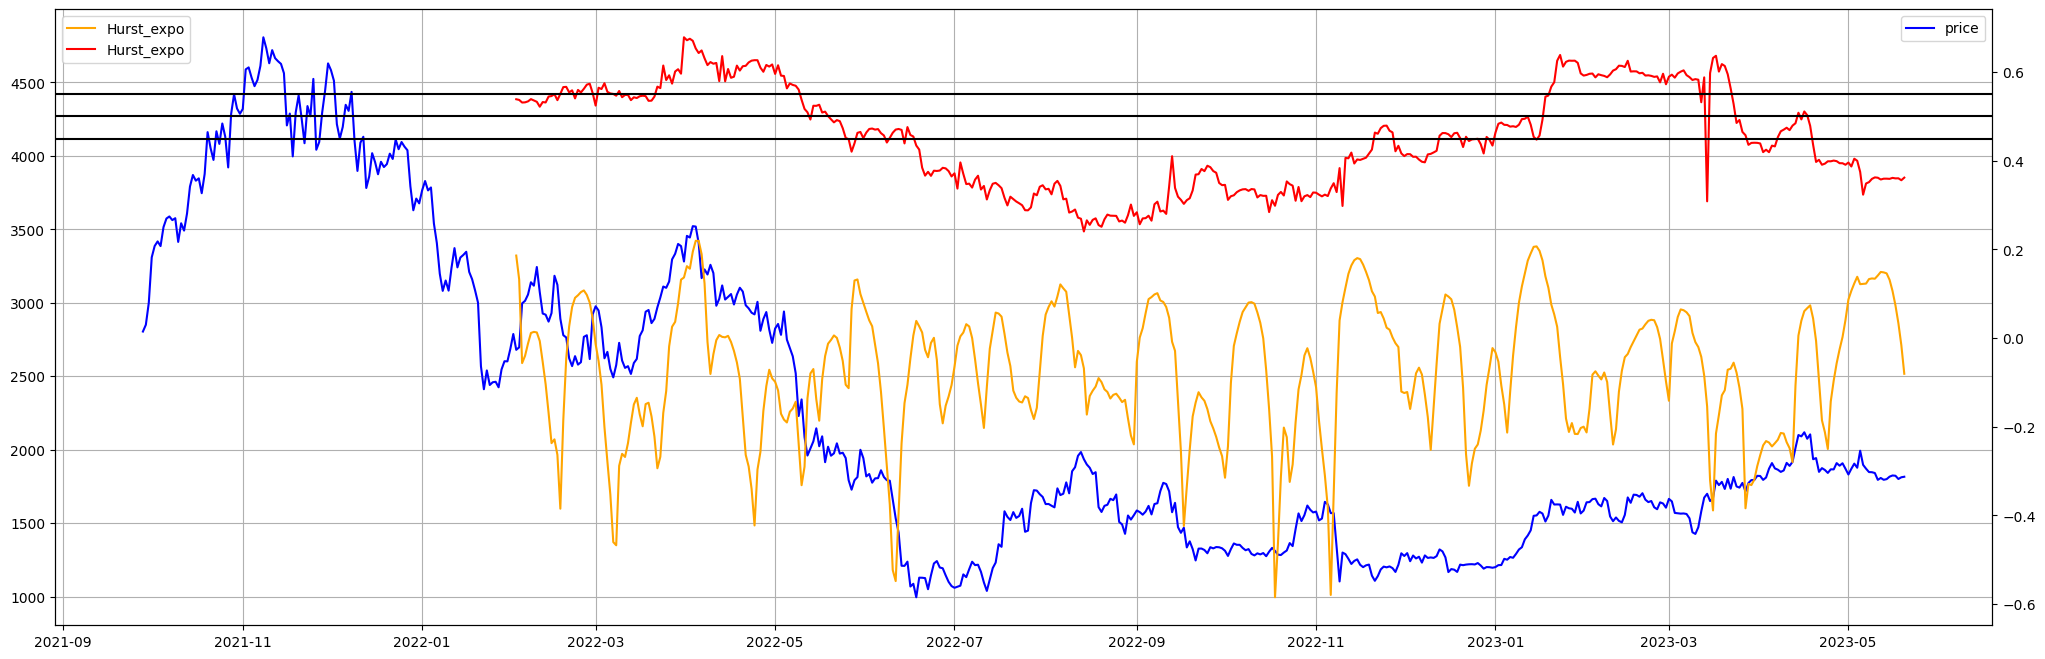

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
ax.plot(df.Close, color="blue", label="price")

ax_left = ax.twinx()
ax_left.plot(df.Hurst_expo, color="orange", label="Hurst_expo")
ax_left.plot(df.Hurst_expo_dsod, color="r", label="Hurst_expo")
ax_left.axhline(y=0.5, color="black")
ax_left.axhline(y=0.55, color="black")
ax_left.axhline(y=0.45, color="black")
ax_left.legend(loc="upper left")
ax.legend()
ax.grid()

# Multifractal Detrended Fluctuation Analysis


In [ ]:
from MFDFA import MFDFA
from MFDFA import fgn

# where this second library is to generate fractional Gaussian noises

# integration time and time sampling
t_final = 2000
delta_t = 0.001

# Some drift theta and diffusion sigma parameters
theta = 0.3
sigma = 0.1

# The time array of the trajectory
time = np.arange(0, t_final, delta_t)

# The fractional Gaussian noise
H = 0.7
dB = (t_final**H) * fgn(N=time.size, H=H)

# Initialise the array y
y = np.zeros([time.size])

# Integrate the process
for i in range(1, time.size):
    y[i] = y[i - 1] - theta * y[i - 1] * delta_t + sigma * dB[i]


In [ ]:
# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 2

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag, dfa = MFDFA(y, lag=lag, q=q, order=order)


Estimated H = 1.711


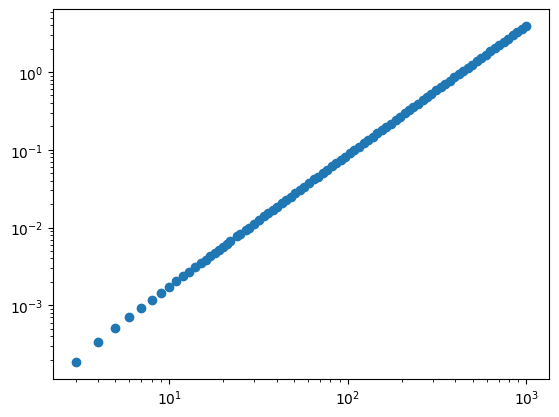

In [ ]:
# To uncover the Hurst index, lets get some log-log plots
plt.loglog(lag, dfa, "o", label="fOU: MFDFA q=2")

# And now we need to fit the line to find the slope. Don't
# forget that since you are plotting in a double logarithmic
# scales, you need to fit the logs of the results
H_hat = np.polyfit(np.log(lag)[4:20], np.log(dfa[4:20]), 1)[0]

# Now what you should obtain is: slope = H + 1
print("Estimated H = " + "{:.3f}".format(H_hat[0]))
